## A more complex example

In this example we will simulate a simple [autocolimator](https://en.wikipedia.org/wiki/Autocollimator) system.

The autocolimator system will be made of a point source (**R**), a beam splitting cube (**BS**), a colimator lens (**L**), and a CCD (**C**).

In this first example, this will be used to check if a mirror (**M1**) is parallel to the optical axis.


In [1]:
from pyoptools.all import *
from numpy import pi

Loading component library Edmund  from files  ['/usr/lib/python3/dist-packages/pyoptools/raytrace/library/Edmund/edmund_spherical.cmp']
Loading component library Thorlabs  from files  ['/usr/lib/python3/dist-packages/pyoptools/raytrace/library/Thorlabs/thorlabs_spherical.cmp']
Loading component library EdmundHome  from files  ['/home/richi/.pyoptools/library/EdmundHome/SphOptics.cmp']


In [40]:
R=point_source_c(span=(0.06,0.06),num_rays=(5,5),wavelength=.65)
BS=BeamSplittingCube(size=25,reflectivity=.5,material=material.schott["BK7"])
L=library.Edmund.get("32494")
C=CCD()
M1= RectMirror(size=(25, 25, 5),material=material.schott["BK7"], reflectivity=1.)

S=System(complist=[(C,(20,0,20),(0,pi/2,0)),(BS,(0,0,20),(0,0,0)),(L,(0,0,158.5),(0,-pi,0)),(M1,(0,0,170),(0,0,0))],n=1.)


S.ray_add(R)
S.propagate()

In [41]:
Plot3D(S,center=(0,0,300), size=(600,100),scale=2,rot=[(0,0,-3*pi/8),(0,3*pi/8,0)])

Renderer(camera=OrthographicCamera(bottom=-100.0, children=(DirectionalLight(intensity=0.7, position=(0.0, 100…

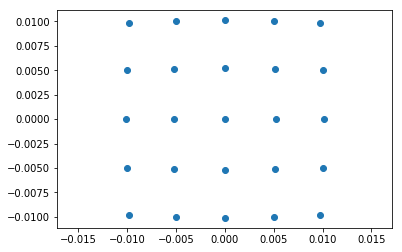

In [42]:
spot_diagram(C)

In the next example the mirror will be tilted 10 urads

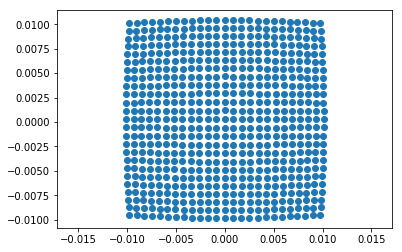

In [72]:
R=point_source_c(span=(0.06,0.06),num_rays=(25,25),wavelength=.65)
BS=BeamSplittingCube(size=25,reflectivity=.5,material=material.schott["BK7"])
L=library.Edmund.get("32494")
C=CCD()
M1= RectMirror(size=(25, 25, 5),material=material.schott["BK7"], reflectivity=1.)

S=System(complist=[(C,(20,0,20),(0,pi/2,0)),(BS,(0,0,20),(0,0,0)),(L,(0,0,158.5),(0,-pi,0)),(M1,(0,0,170),(1.E-6,0,0))],n=1.)


S.ray_add(R)
S.propagate()

spot_diagram(C)

In [73]:
cx=0.
cy=0.

for c,r in C.hit_list:
    cx=cx+c[0]
    cy=cy+c[1]
print(cx/25, cy/25)

print((cy/(25*25)/158.5))


1.5020235055729358e-13 0.007495630361423743
1.8916417315895882e-06


In this case, the resulting spot diagram is similar to the previous one, but we can see the central spot is not located at the origin of the **CCD** anymore.

In [50]:
.003/158.5

1.892744479495268e-05

In [47]:
arctan2(.0025,158.5)

1.5772870661152557e-05

In [ ]:
BS=BeamSplitingCube(size=25,reflectivity=.5,material=material.schott["BK7"])
L=library.Edmund.get("32494")
M2=Component(surflist=[(Spherical(shape=Circular(radius=20),curvature=1./1000,reflectivity=1),(0,0,0),(0,0,0))])

C=CCD()

#Nota, hay problemas si existe una cavidad resonante
S=System(complist=[(C,(20,0,20),(0,pi/2,0)),(BS,(0,0,20),(0,0,0)),(L,(0,0,176.5),(0,-pi,0)),(M2,(0,0,570),(.0,0,0))],n=1.)
R=point_source_c(span=(0.06,0.06),num_rays=(5,5),wavelength=.65)


S.ray_add(R)
S.propagate()


In [ ]:
Plot3D(S,center=(0,0,300), size=(600,100),scale=2,rot=[(0,0,-3*pi/8),(0,3*pi/8,0)])

In [ ]:
spot_diagram(C)